# Project 2: Newton vs the machine: <br/>*solving the chaotic three-body problem using deep neural networks*
## Learning from data [TIF285], Chalmers, Fall 2022

Last revised: 10-Oct-2022 by Christian Forssén [christian.forssen@chalmers.se] and Shahnawaz Ahmed [shahnawaz.ahmed@chalmers.se]

## Instructions

- See deadline on the course web page
- This project is performed in groups of two students. 
- The second part of the project is optional. See examination rules on the course web page.
- Hand-in your written report and your solution source code via Canvas. 
- Please also upload your ANN model with the trained parameters as `myNN.h5` using the keras `save_model` method: `tf.keras.models.save_model(model, 'myNN.h5')`, which employs the compact, binary [hdf5](https://www.hdfgroup.org/solutions/hdf5/) file format.

### Written report
- Page limit: 6 pages (excluding title page and list of references). 3 extra pages are allowed when doing also the optional extra task.
- Give a short description of the nature of the problem and the methods you have used.
- Include your results either in figure form or in a table. All tables and figures should have relevant captions and labels on the axes.
- Try to give an interpretation of you results.
- Upload the source code of your program as a separate file (.ipynb or .py). Comment your program properly.

### Learning goals:
* Apply deep neural networks to build an emulator for a physics problem that is difficult and costly to solve numerically.
* Get familiar with [tensorflow](https://www.tensorflow.org/), the popular open-source library to train ML models created by the Google Brain team.
* Get experience with some diagnostics used in the training of neural networks. 
* Understand the difficulties and choices involved when training a deep neural network.
* This a less-guided set of tasks and you will have to put together ideas and tools we've discussed.
* Reproduce scientific results from a published paper.

## Main task
The overall project goal is to reproduce various results in a paper: [*Newton vs the machine: solving the chaotic three-body problem using deep neural networks*](https://arxiv.org/abs/1910.07291) by Philip G. Breen, Christopher N. Foley, Tjarda Boekholt, Simon Portegies Zwart.

The authors have graciously agreed that we use the raw data from their study for this project (but please don't distribute any further).

### Physical problem

In this project we are studying the motion of three bodies of equal mass that move under the mutual influence of classical gravitational forces. Due to the system's chaotic nature, the solution to this problem for a given initialization can only be found by performing laborious iterative numerical calculations that have unpredictable and potentially infinite computational cost. 

Here you will demonstrate that a deep artificial neural network (ANN) is able to learn the solutions to the equations of motion from a set of numerical training data. This ANN can then provide good approximations for new initial conditions at a fixed (and small) computational cost.

The training data that we will be using was generated with a state-of-the-art numerical code `Brutus` [[Boekholt, T., Portegies Zwart, S. On the reliability of N-body simulations. Comput. Astrophys. 2, 2 (2015).](https://doi.org/10.1186/s40668-014-0005-3)]. The run time of that code for the trajectories studied here ranges from minutes up to hours. In the end, it will therefore be relevant to quantify what is the computational cost of making a prediction with our constructed ANN.

### Initial condition and choice of coordinates
- We work in the the center-of-mass (CM) frame and only consider the scenario in which the three masses start from rest.
- It can be shown that, without loss of generality, it is always possible to choose a coordinate system such that the three particles $p_1, p_2, p_3$ move in a plane so that just $(x,y)$ coordinates are needed.
- Furthermore, the $(x,y)$ coordinates can be chosen and scaled such that particle 1 starts in position $(1,0)$ and the initial position of particle 2 is located in the second quantile ($x<0$, $y>0$).
- Since we are in the CM frame and our systems consists of three equal masses we will always have $x_1+x_2+x_3=0$ and $y_1+y_2+y_3=0$. Consequently, we can determine the position of particle 3 from knowledge of the positions of particles 1 and 2.

See also Fig. 1 in the paper.

### Data
The data that you should use is made available as a compressed numpy file on the Canvas course page. 

Navigate to Files > Project2  and download `data_project2.npz` (or directly via this link:
<a href="https://chalmers.instructure.com/files/1674468/download?download_frd=1" title="data_project2.npz" class="instructure_file_link">data_project2.npz</a>)

In [1]:
# Load modules
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Add your own import statements if needed

from copy import deepcopy #Is this module allowed?
import math
from keras.callbacks import CSVLogger

In [2]:
# Load and unpack a compressed npy array
load_data = np.load('data_project2.npz')
data = load_data['arr_0']
print(data.shape)

(9000, 1000, 9)


- The first axis labels the 9000 data samples.
- The second axis is the 1000 time steps, which corresponds to 3.9 time units. The original data is composed of 2561 time steps, reaching 10 time units, but as discussed in the paper the training of the ANN works better for the somewhat shorter time interval.
- The nine columns of the last axis correspond to: $[t, x_1, y_1, x_2, y_2, v_{x,1}, v_{y,1}, v_{x,2}, v_{y,2}]$ (note again that the position of particle 3 can be obtained from the positions of particles 1 and 2). The velocity data is only used in the extra task.
- Some of the trajectories contain collisions such that the positions of the particles get stuck at (0, 0). Check the data to find those trajectories and remove them before training your model.
- Note that the trajectories are represented by data points in sets of 1000 (time steps). While creating batches of data, make sure you are not mixing part of the data from one trajectory with a different trajectory.

### List of tasks
1. Download and load the pre-trained ANN from the paper (see below) and construct your own ANN using the provided data. Compare the complexity (number of trainable parameters) in the pre-trained versus your own ANN.
1. Show the Mean Absolute Error (MAE) vs epoch from the training of your own ANN (as in Fig. 3 of the paper). I.e. you should show both the MAE metric on the training and the validation data.
1. Check the accuracy of the pre-trained ANN by showing some trajectories and the ANN prediction as in Fig. 4 of the paper. Add also the trajectory of your ANN and comment on its performance.
1. Check the computational cost of making a prediction with the ANN. You will find that it is much shorter than the numerical integration performed by `Brutus` (which according to the reference takes minutes to hours for finding a trajectory).
1. Having access to these ANN emulators you can explore the chaotic aspect of this motion by creating a hundred different trajectories from a slightly disturbed initial condition. Try to reproduce Fig. 5 in the paper (both with the pre-trained and your own ANN).

### Suggestions for how to proceed:
* Follow the lead of the demo notebook for using tensorflow / keras (plus see the hints below).
* First download and load the data set and the ANN from the paper (both available on the Canvas course page. Navigate to Files > Project2; see hint below)
* It is suggested (but not required) to create helper functions (see hints below): 
  * `get_data` for extracting a trajectory (positions of particle 1 as a function of the discrete time) from the data; 
  * `get_trajectories` for generating the positions of all particles from a prediction output that contains the arrays of the first two particles' positions; 
  * `plot_trajectories` for plotting a trajectory.
* When creating your own ANN it is suggested that you first design a smaller one than in the paper (e.g., using five dense layers with 64 neurons in each) and analyse how it performs by looking at the training vs validation error. The creation of a large network with ten layers and 128 nodes per layer is optional (and might require more cpu-hours for training).
* Try first with the `relu` activation function and the `Adam` optimizer with a learning rate of 0.001 and moments of 0.5 (these hyper-parameters can easily be changed if you want; see hints below). 
    - The choice of optimizer  and hyper-parameters such as learning rate can certainly influence your results. For the interested, there is a recent extensive guide with open-source experimental results published here: https://arxiv.org/abs/2007.01547.
* Use 90% of the data for training and 10% for validation. You probably need at least hundred epochs for training and it is suggested to split the data into 10-100 batches (see hints below).

### Comments and hints
* Download the pre-trained ANN model (<a href="https://chalmers.instructure.com/files/1674480/download?download_frd=1" title="Breen_NN_project2.h5" class="instructure_file_link">Breen_NN_project2.h5</a>) and load it with: `pre_trained_model = keras.models.load_model("Breen_NN_project2.h5")`. This file is also included in the gzipped tarball that contains the project 2 files.
* The ANN input should be an array with three elements: $[t,x_2,y_2]$, where the last two will be the initial position of particle 2 and the first one is the time step for which the particle positions should be predicted. Remember that particle 1 always starts in $(1,0)$. 
* Input data corresponding to a single trajectory is then of shape $1000 \times 3$ where the first column contains the time steps while the $x_2,y_2$ columns are repetitions of the initial position.
* I.e., the inputs to the `tensorflow` network is a tensor with three columns where the second and third columns have values that are repeated (with values of the initial position at [t=0]) for all the rows corresponding to a single trajectory.
* The output should be an array with four elements $[x_1,y_1,x_2,y_2]$ that corresponds to the positions of particles 1 and 2 at the time step $t$ from the input. Again, we can consider a tensor (batch) of outputs corresponding, e.g., to a full trajectory.
* As mentioned, some of the trajectories contain collisions such that the positions of the particles get stuck at (0, 0). Check the data to find those trajectories and remove them before training your model.
* The data can be turned into a `tensorflow` dataset using: `dataset = tf.data.Dataset.from_tensor_slices((x, y))`, where `x` and `y` are input and output data, respectively (you might possibly need to reshape using `x.reshape(-1, 3)` and `y.reshape(-1, 4)`)
* Having created a dataset, e.g. `train_dataset`, you can make batches (e.g. with batchsize 5000) with `train_dataset = train_dataset.batch(5000)`. The same should then be done for the validation data. As mentioned, the trajectories are represented by data points in sets of 1000 (time steps). While creating batches of data, make sure you are not mixing part of the data from one trajectory with a different trajectory. 
* When compiling a `tensorflow` model, with `model.compile()`, the Adam optimizer can be specified via the argument `optimizer=keras.optimizers.Adam(0.001, 0.5, 0.5)`
* Furthermore, the loss function can be chosen using the argument `loss=keras.losses.MeanAbsoluteError()`
* Fitting the model for 100 epochs with specified training and validation data sets can be performed with: `model.fit_generator(train_dataset, epochs=100, validation_data = test_dataset)`
* Given the cost of training the network with all data, it is not required to make extensive tests of tuning the hyperparameters.
* More exact timing of a function can be measured using ["Jupyter notebook magic"](https://towardsdatascience.com/the-top-5-magic-commands-for-jupyter-notebooks-2bf0c5ae4bb8) by putting the command to be measured in a notebook cell that starts with `!timeit`. This will run the cell many times and report the mean and standard deviation of the evaluation time.

#### Helper function docstrings
The following are just suggestions. You are allowed to construct a solution using your own helper functions.

In [3]:
def data_filter(data):
    '''
    Identifies converging trajectories within the provided array of data and returns
    a new filtered array of data. Only suited for data of the shape (9000,1000,9).

    Args:
        Data (array): Array of trajectory data of the shape (9000,1000,9) where
        - index 0 = Amount of data samples
        - index 1 = Amount of time steps
        - index 2 = Motion variables [t,x1,y1,x2,y2,v_x1,v_y1,v_x2,v_y2]

    Returns:
        Data_filtered (array): A filtered data array containing all non-converging trajectories. 
    '''
    # Creates a deep copy of the input data
    data_filtered = deepcopy(data)

    # We look for the indexes of the converging data samples
    index = []

    for i in range(9000): # i:th data sample
        # We look for convergences every 10th time step
        data_i = data_filtered[i][::10]

        for j in range(100): #j*10:th time step
            # The 0:th element is the time element, which we aren't interested in
            data_ij = data_i[j][1:]

            # If all positions and velocities = 0, add the index to the list
            # and break the loop, proceeding to sample i+1
            if all(x == 0 for x in data_ij) == True:
                index.append(i)
                break
    
    # The final 0 specifies axis 0 - the data sample axis
    data_filtered = np.delete(data_filtered[:],index,0)

    return data_filtered

# Filtered data
valid_data = data_filter(data)

print(valid_data.shape)


(7623, 1000, 9)


In [4]:
def get_data(idx):
    """
    Get one training instance from the data set at the index idx. 
    
    The data is assumed to be in an array `data`.
    
    Args:
        idx (int): An integer specifying which of the training example to fetch
        
    Returns:
        x (array): An array of shape (time_steps, 3) which specifies the input to
                   the neural network. The first column is the time and the second
                   and third columns specify the (x, y) coordinates of the second
                   particle. Note that the first particle is always assumed to be
                   at (1, 0) and the third particle can be inferred from the first
                   and second particle's position.
                   
        y (array): An array of shape (time_steps, 4) which specifies the output that 
                   is expected from the neural network.
                   
                   The first two columns specify the (x, y) coordinates of the first
                   particles and the next two columns give the coordinates of the 
                   second particle for the specified time (length of the columns).
                   The third particles position can be inferred from the first
                   and second particle's position.
    """
    # Empty arrays to be filled
    x = np.empty((0,3))
    y = np.empty((0,4))

    # Variables are structured as [t,x1,y1,x2,y2,v_x1,v_y1,v_x2,v_y2]
    # -> [0] = t, [3:5] = x2,y2

    # -> [:5] = t,x1,y1,x2,y2
    for i in range(1000): 
        x_i = [np.append(valid_data[idx][i][0], valid_data[idx][i][3:5])]
        y_i = [valid_data[idx][i][1:5]]

        x = np.concatenate((x,x_i))
        y = np.concatenate((y,y_i))
    
    return x,y

In [5]:
# We divide the data into training and test sets.
# The first 90% of the data samples are used as training samples
# and the latter 10% as test samples
'''
train_index = np.arange(0,int(.9 * len(valid_data[:,0,0])))
test_index  = np.arange(int(.9 * len(valid_data[:,0,0])),len(valid_data[:,0,0]))

x_train = [get_data(i)[0] for i in train_index]
y_train = [get_data(i)[1] for i in train_index]

x_test  = [get_data(i)[0] for i in test_index]
y_test  = [get_data(i)[1] for i in test_index]

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test  = np.array(x_test)
y_test  = np.array(y_test)

# Since these take long to generate, we save them as data files for future use
np.save('x_train',x_train)
np.save('y_train',y_train)
np.save('x_test',x_test)
np.save('y_test',y_test)
'''
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
x_test  = np.load('x_test.npy')
y_test  = np.load('y_test.npy')

# Check to see if the shapes are what we expect them to be
print('x_train: ',x_train.shape)
print('y_train: ',y_train.shape)
print('x_test:  ',x_test.shape)
print('y_test:  ',y_test.shape)

x_train:  (6860, 1000, 3)
y_train:  (6860, 1000, 4)
x_test:   (763, 1000, 3)
y_test:   (763, 1000, 4)


In [6]:
# Old code doing the same thing that the above cell does
'''
# Splitting the data into test (90%) and validation (10%) sets
#mnist = tf.keras.datasets.mnist
#(x_train, y_train), (x_test, y_test) = mnist.load_data()
#print('x_train:',x_train.shape)
#print('x_test: ',x_test.shape)

train_N = math.floor(0.9 * valid_data.shape[0])

test_N = valid_data.shape[0] - train_N

# Generate x_train and y_train
#x_train = np.zeros((train_N,1000,3))
#y_train = np.zeros((train_N,1000,4))

#for i in range(train_N):
#    print(i)
#    x_train[i] = get_data(i)[0]
#    y_train[i] = get_data(i)[1]

#x_train = np.stack(x_train)
#y_train = np.stack(y_train)

# Generate x_test and y_test
x_test = np.zeros((test_N,1000,3))
y_test = np.zeros((test_N,1000,4))

for i in range(test_N):
    print(train_N + i)
    x_test[i] = get_data(i+train_N)[0]
    y_test[i] = get_data(i+train_N)[1]

print(x_test.shape)
print(y_test.shape)
'''

"\n# Splitting the data into test (90%) and validation (10%) sets\n#mnist = tf.keras.datasets.mnist\n#(x_train, y_train), (x_test, y_test) = mnist.load_data()\n#print('x_train:',x_train.shape)\n#print('x_test: ',x_test.shape)\n\ntrain_N = math.floor(0.9 * valid_data.shape[0])\n\ntest_N = valid_data.shape[0] - train_N\n\n# Generate x_train and y_train\n#x_train = np.zeros((train_N,1000,3))\n#y_train = np.zeros((train_N,1000,4))\n\n#for i in range(train_N):\n#    print(i)\n#    x_train[i] = get_data(i)[0]\n#    y_train[i] = get_data(i)[1]\n\n#x_train = np.stack(x_train)\n#y_train = np.stack(y_train)\n\n# Generate x_test and y_test\nx_test = np.zeros((test_N,1000,3))\ny_test = np.zeros((test_N,1000,4))\n\nfor i in range(test_N):\n    print(train_N + i)\n    x_test[i] = get_data(i+train_N)[0]\n    y_test[i] = get_data(i+train_N)[1]\n\nprint(x_test.shape)\nprint(y_test.shape)\n"

In [7]:
def get_trajectories(pred):
    """
    Gets the trajectories from a predicted output pred.
    
    Args:
        pred (array): An array of shape (N, 4) where N is the number of time
                      steps. The four columns give the positions of the particles
                      1 and 2 for all the time steps.
    Returns:
        p1, p2, p3 (tuple of arrays): Three arrays of dimensions (N, 2) where N is the number 
                             of time steps and the two columns for each array give 
                             the positions of the three particles (p1, p2, p3)
    """
    # The following code does not work for standard Python arrays
    pred = np.array(pred)

    # p1 and p2 are simply the columns of pred
    p1 = pred[:,[0,1]]
    p2 = pred[:,[2,3]]

    # Since p1 + p2 + p3 = [0,0]
    p3 = -(p1+p2)

    return p1,p2,p3

In [8]:
def plot_trajectories(p1, p2, p3, ax=None, **kwargs):
    """
    Plots trajectories for points p1, p2, p3
    
    Args:
        p1, p2, p3 (array): Three arrays each of shape (n, 2) where n is the number
                            of time steps. Each array is the (x, y) position for the
                            particles
        ax (axis object): Default None, in which case a new axis object is created.
        kwargs (dict): Optional keyword arguments for plotting
        
    Returns:
        ax: Axes object
    """
    fig = plt.figure(figsize=(10,10)) 
    plt.plot(p1[:,0],p1[:,1],color='red')
    plt.plot(p2[:,0],p2[:,1],color='blue')
    plt.plot(p3[:,0],p3[:,1],color='green')

In [9]:
# Creating our ANN and importing the pre-trained one
ANN = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3)),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(4,activation='softmax')
])

# Adding relevant settings to the model
ANN.compile(optimizer=keras.optimizers.Adam(0.001, 0.5, 0.5),
            loss=keras.losses.MeanAbsoluteError(),
            metrics=['accuracy'])

# Saving the model
#tf.keras.models.save_model(ANN,'layers5nodes64.h5')

# Creating tensorflow datasets and dividing them into batches
# These will be used during training
data_train = tf.data.Dataset.from_tensor_slices((x_train.reshape(-1,3), y_train.reshape(-1,4)))
data_test  = tf.data.Dataset.from_tensor_slices((x_test.reshape(-1,3), y_test.reshape(-1,4)))

data_train = data_train.batch(30)
data_test  = data_test.batch(30)

# Importing the ANN made by Breen et al
ANN_breen = tf.keras.models.load_model('Breen_NN_project2.h5')

In [10]:
# Summaries of the two models
ANN.summary()
ANN_breen.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                256       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                4

In [11]:
# Training our model and saving it to a .csv-file
csv_log = CSVLogger('history_ep100_ba30.csv',separator=',',append=False)
history = ANN.fit_generator(data_train, epochs=100, validation_data = data_test,
            callbacks = [csv_log])

Epoch 1/100


<ipython-input-11-41a93b5ff3a9>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = ANN.fit_generator(data_train, epochs=100, validation_data = data_test,


228667/228667 [==============================] - 296s 1ms/step - loss: 0.3316 - accuracy: 0.7463 - val_loss: 0.3478 - val_accuracy: 0.6284
Epoch 2/100
228667/228667 [==============================] - 293s 1ms/step - loss: 0.3298 - accuracy: 0.7539 - val_loss: 0.3494 - val_accuracy: 0.6855
Epoch 3/100
228667/228667 [==============================] - 290s 1ms/step - loss: 0.3326 - accuracy: 0.7421 - val_loss: 0.3512 - val_accuracy: 0.6953
Epoch 4/100
228667/228667 [==============================] - 288s 1ms/step - loss: 0.3341 - accuracy: 0.7326 - val_loss: 0.3524 - val_accuracy: 0.6852
Epoch 5/100
228667/228667 [==============================] - 292s 1ms/step - loss: 0.3346 - accuracy: 0.7308 - val_loss: 0.3519 - val_accuracy: 0.6968
Epoch 6/100
228667/228667 [==============================] - 285s 1ms/step - loss: 0.3362 - accuracy: 0.7269 - val_loss: 0.3591 - val_accuracy: 0.6848
Epoch 7/100
228667/228667 [==============================] - 287s 1ms/step - loss: 0.3434 - accuracy: 0.71

[0.33164727687835693, 0.3298129141330719, 0.3325861096382141, 0.3341088891029358, 0.33458656072616577, 0.33616364002227783, 0.34335243701934814, 0.3424903452396393, 0.3414057195186615, 0.34208789467811584, 0.3444039821624756, 0.34354493021965027, 0.34357914328575134, 0.3429783582687378, 0.3418124318122864, 0.34225213527679443, 0.3451199233531952, 0.3443991541862488, 0.3450143337249756, 0.3426528871059418, 0.34123754501342773, 0.340973436832428, 0.3413394093513489, 0.341472864151001, 0.3413172662258148, 0.3422985076904297, 0.3429655134677887, 0.3451630175113678, 0.34805068373680115, 0.35041335225105286, 0.3549745976924896, 0.35388779640197754, 0.3522963523864746, 0.3533829152584076, 0.34753328561782837, 0.3478124141693115, 0.34797871112823486, 0.347703218460083, 0.3477436602115631, 0.3507222533226013, 0.35490676760673523, 0.358437180519104, 0.3608610928058624, 0.36638110876083374, 0.3669528365135193, 0.36012011766433716, 0.3552148640155792, 0.3668566942214966, 0.3647889494895935, 0.3644

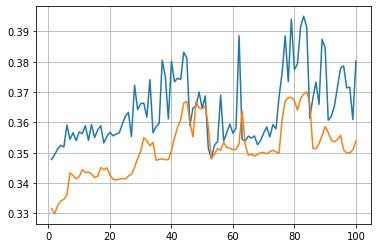

In [13]:
# Comparison of training and testing MAEs

# Save temporary data
# np.save('test_history',history.history)

# Load saved data using temp_data = np.load('name',allow_pickle=True)
# and use the dict through temp_data.item().get('value of interest')

# We fetch MAEs from the fit
MAE_train = history.history['loss']
MAE_test  = history.history['val_loss']
epochs    = np.arange(1,len(MAE_train)+1) # +1 since epochs start at 1, not 0
print(history.history['loss'])

plt.plot(epochs,MAE_test)
plt.plot(epochs,MAE_train)
plt.grid()

In [ ]:
# Fetching the MAE of Breen's model
breen_stats = ANN_breen.evaluate(x_test.reshape(-1,3),y_test.reshape(-1,4))
our_stats = ANN.evaluate(x_test.reshape(-1,3),y_test.reshape(-1,4))

In [ ]:
print(breen_stats.history['loss'])

## Optional: Part 2 (extra task)
* Create a helper function that extracts the velocity at each time step.
* Compute the potential energy and the kinetic energy at each time step. The units are chosen such that the total energy is just the sum of these two.
* Check for the conservation of energy in: (i) the data generated by `Brutus` (note that the velocities are given in the last few columns of the data file); (ii) the pre-trained model from the paper; (iii) your ANN model.
* Create a custom loss function and re-train your model to be trained (constrained) by energy conservation. (Unfortunately, you should not expect any significant improvement in the model with the energy-conserving loss function.)
* Reproduce Fig. 6 (with the green line being replaced by your energy-conserving ANN). 

### Comments and hints

* You should probably define helper functions that compute potential energies, velocities and kinetic energies for points along a trajectory. Note that the masses start from rest.
* In order to construct a `tensorflow` custom loss you will need `@tf.function()` versions of the same helper functions. Within these you can only use `tensforflow` methods such as: `tf.concat()` and `tf.math.sqrt()` (i.e., `numpy` methods cannot be used for these functions). 
* See (suggested) `tensorflow` helper functions docstrings below. 
* You can define a custom loss function that assumes a batch size that is equal to the number of time steps in a trajectory. You should also make sure that the data is not shuffled so that a batch always corresponds to a trajectory. Then you can use a global time array to be used to extract velocities and therefore kinetic energies.
* See a suggested structure of the custom loss below. You might get problems with very large kinetic and potential energies for trajectories with close encounters. A suggestion is to clip very large values of `energy_error` in the return statement of the custom energy loss by `tf.clip_by_value(energy_error, -1e6, 1e6)`. 
* The custom loss is then used in `model.compile()` via the argument `loss=custom_energy_loss`.

#### Helper function docstrings
The following are just suggestions. You are allowed to construct a solution using your own helper functions.

In [ ]:
import tensorflow as tf
from tensorflow import keras

@tf.function()
def tf_ediff1d(a):
    """
    TensorFlow equivalent of 1D difference.
    
    Args:
        a (array): A TensorFlow array of dimension (N, 1)
        
    Returns:
        diff (array): An array which gives the difference of successive elements of a.
    """
    raise NotImplementedError

@tf.function()
def tf_compute_velocities(t, p):
    """
    Computes the velocities of the particles from the trajectories starting from rest.
    
    Args:
        t (array[float]): An array of shape (N, 1) giving time steps.
        p (array): An array of dimension (N, 2) where N is the number 
                   of time steps and the two columns give the coordinates
                   of the particle.
                             
    Returns:
        v (array): An array of dimension (N, 2) where N is the number 
                   of time steps and the two columns for each array give 
                   the x and y components for the instantaneous velocity
                   of the particle.
    """
    raise NotImplementedError

@tf.function()
def tf_compute_kinetic_energy(v):
    """
    Computes the kinetic energy for the given velocity vectors
    
    Args:
        v (array): A (N,2) array of veolcities for N time steps.
        
    Returns:
        ke (array): An array of shape (N, 1) giving the kinetic energies at each time step.
    """
    raise NotImplementedError

@tf.function()
def tf_compute_potential_energy(p1, p2, p3):
    """
    Computes the potential energy for the given position vectors. The value of the 
    gravitational constant is taken as 1 (G=1). The masses are the same value (m=1)
    
    Args:
        p1, p2, p3 (tuple of arrays): Three arrays of dimensions (N, 2) where N is the number 
                             of time steps and the two columns for each array give 
                             the positions of the three particles (p1, p2, p3)
                             
    Returns
        pe (array): An array of shape(N, 1) giving the potential energy at each time step
        
    """
    raise NotImplementedError

In [ ]:
# Suggested structure of the custom loss function
tlist = ... # Which will be used in the custom loss

def custom_loss(y, y_pred):
    """
    A custom loss function computing error in energy conservation.
    """
    predicted_positions = ... # Obtained from y_pred
    predicted_velocities = ... # Obtained from predicted_positions, tlist

    initial_potential_energy = ... # Obtained from positions (y)

    ke_predicted_trajectory = ...# Obtained from predicted_velocities
    pe_predicted_trajectory = ... # Obtained from predicted_positions

    error = (ke_predicted_trajectory + pe_predicted_trajectory -
                 initial_potential_energy)

    energy_loss = tf.reduce_mean(tf.abs(error))
    # The relative weight ofthe two terms in the custom loss might be tuned.
    return tf.keras.losses.MeanAbsoluteError()(y, y_pred) + 0.001*energy_loss